In [1]:
print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Sythetic data: automatic classification generator

## ToDos

1. make it automatic to find stays and add individual noise to them
    1. ~~find stays $\to$ could be used for later labeling and training~~ $\to$ **done!**
        * ~~**important** this can help validate the algo.~~ 
    2. add individual noise to stays to make them location- and stay-specific
    3. make same noise for stays at same $x$?
2. Add new functionality to `synthetic_data` module

In [4]:
import importlib
from stay_classification import synthetic_data

In [5]:
xxx = np.arange(0,100,0.1)

In [7]:
importlib.reload(synthetic_data);
from stay_classification.synthetic_data import get_1bump, get_bumps, get_noisy_bumps

## Create an automatic classification

Generate the automatic classification for sythetic data

### Load initial data

In [140]:
dc = {
        "bump1_amp":  0.5, "bump1_slope": 1.015, "bump1_start":  20 , "bump1_end": 40,
        "bump2_amp": -0.5, "bump2_slope": 1.015, "bump2_start": 40 , "bump2_end": 70
     }

dc_noise = {"bump1_eta": 0.015, "bump2_eta": 0.125}

yyy = get_bumps(xxx, **dc)

yyyn = get_noisy_bumps(xxx, **{**dc, **dc_noise})

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')
plt.plot(xxx, yyyn, 'x')
plt.grid()

### Compute gradient of profile

Since the underlying profiles as simple, regions where the gradient is close to zero indicates a stay
* in fact, this notion underlies any stay identification

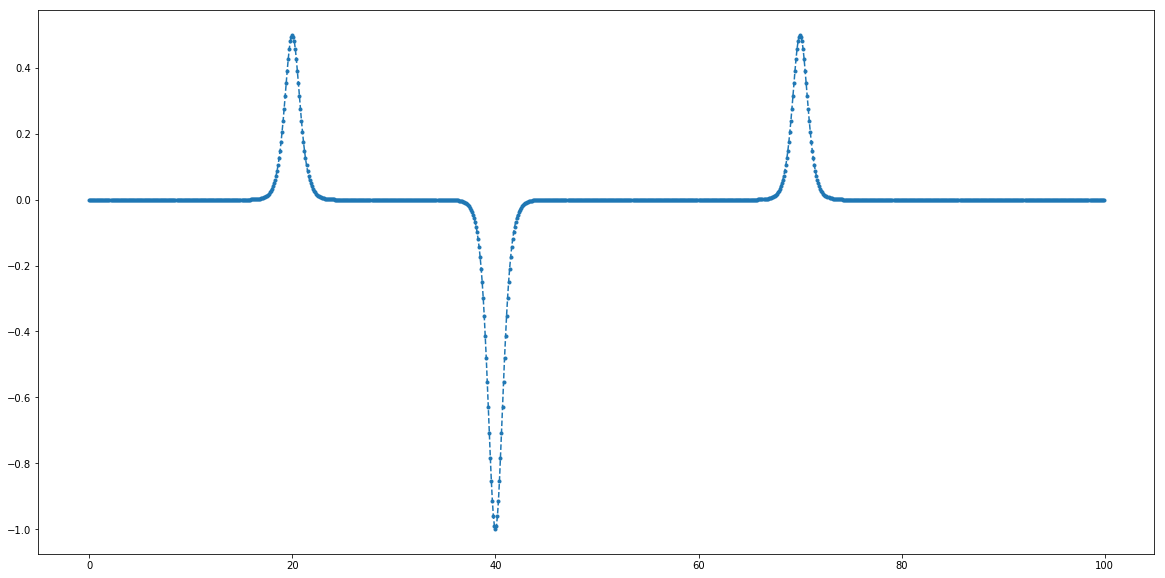

In [156]:
grad = np.gradient(yyy,0.01)
grad = grad/(np.max(np.abs(grad)))

plt.figure(figsize=(20,10))
plt.plot(xxx, grad, '.--')

### Increase the stays by steepening the gradient

In [246]:
# 1. Get the slopes in the profile config dict., and increase (ie steepen)
dc_class = dc.copy()
for k,v in dc_class.items():
    if "slope" in k: dc_class[k] = 2.0*v

# 2. Generate new profile with steeper slopes
yyy_classify = get_bumps(xxx, **dc_class)

# 3. Compute gradient of steeper profile
#tight_grad = np.abs(np.gradient(np.abs(yyy_classify),0.01))
tight_grad = np.gradient(yyy_classify,0.01)
tight_grad = tight_grad/np.max(np.abs(tight_grad))
#new_grad = (1.0-grad) # Invert to keep stays at 1

'''
# X. Check if there is a spike (not needed when no abs)

for n in range(1,new_grad.size-1):
    
    if (abs(new_grad[n]-new_grad[n-1]) > 0.5) & \
       (abs(new_grad[n+1]-new_grad[n]) > 0.5):
            new_grad[n]+=0.5
    
'''
# 4. Create an array of indices where the stays are located
class_mask=np.where(np.abs(new_grad) <= 0.0005)

### Generate a map for index to stays
* "0" for travel
* "1" for stay

In [247]:
get_class = lambda n: 1 if n in class_mask[0].tolist() else 0
classification_map = {n:get_class(n) for n in range(xxx.size) }

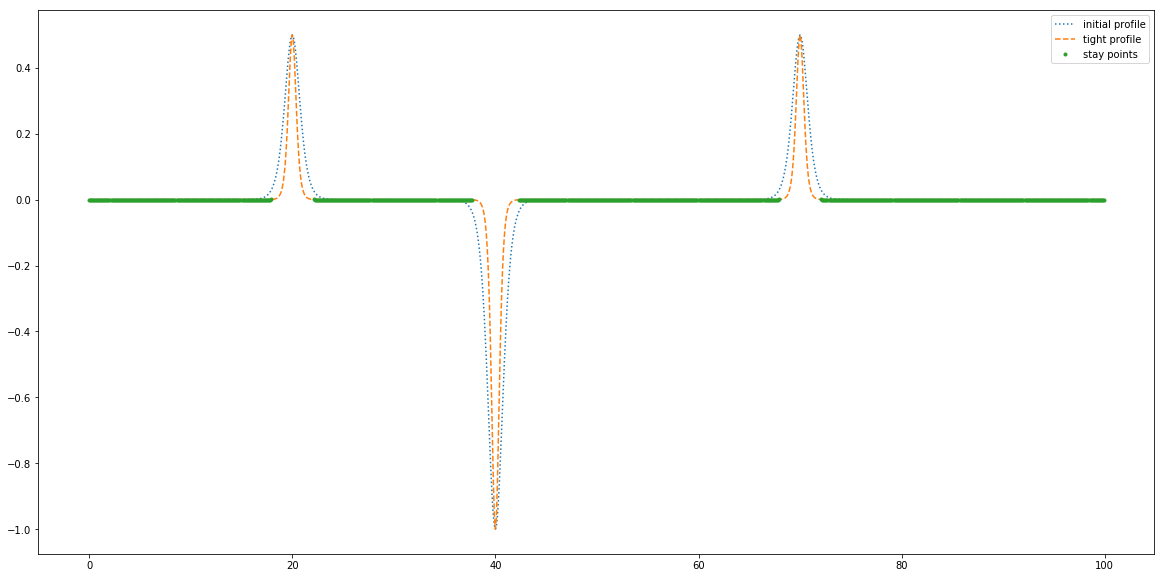

In [248]:
plt.figure(figsize=(20,10))
plt.plot(xxx, grad, linestyle=':', label='initial profile')
plt.plot(xxx, tight_grad, '--', label='tight profile')
plt.plot(xxx[class_mask], new_grad[class_mask], '.', label='stay points')
plt.legend();

In [66]:
from stay_classification.synthetic_data import get_mask

In [275]:
# Get all indices
all_indices = np.arange(0,xxx.size)

# Get the sparsed indices
sparse_mask = get_mask(xxx.size, 1.00)
sparse_mask_set = set(all_indices[sparse_mask])

# Get the classified (stay) indices
mask_set = set(class_mask[0].tolist())
residual_set = set(all_indices).difference(mask_set)

# Intersect the classification masks with sparse mask
mask_set = mask_set.intersection(sparse_mask_set)
residual_set = residual_set.intersection(sparse_mask_set)

# Get the individual sparsified, classificaiton masks
stay_mask = np.array(sorted(list(mask_set)))
trav_mask = np.array(sorted(list(residual_set)))

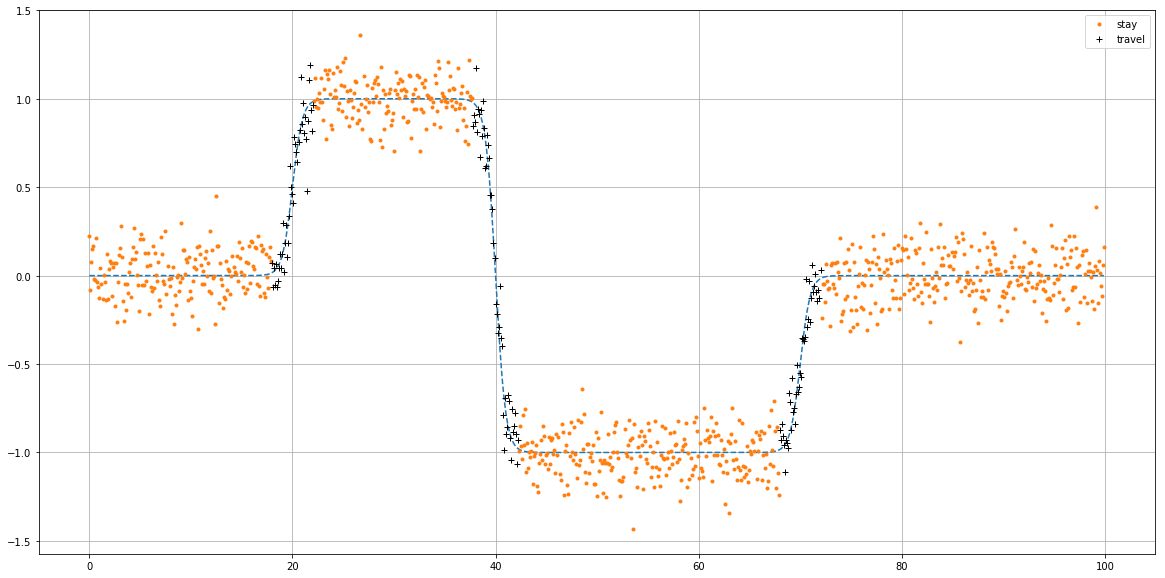

In [276]:
plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')
plt.plot(xxx[stay_mask], yyyn[stay_mask], '.', label='stay')
plt.plot(xxx[trav_mask], yyyn[trav_mask], 'k+', label='travel')
plt.grid()
plt.legend();

### With indexed stays/travels

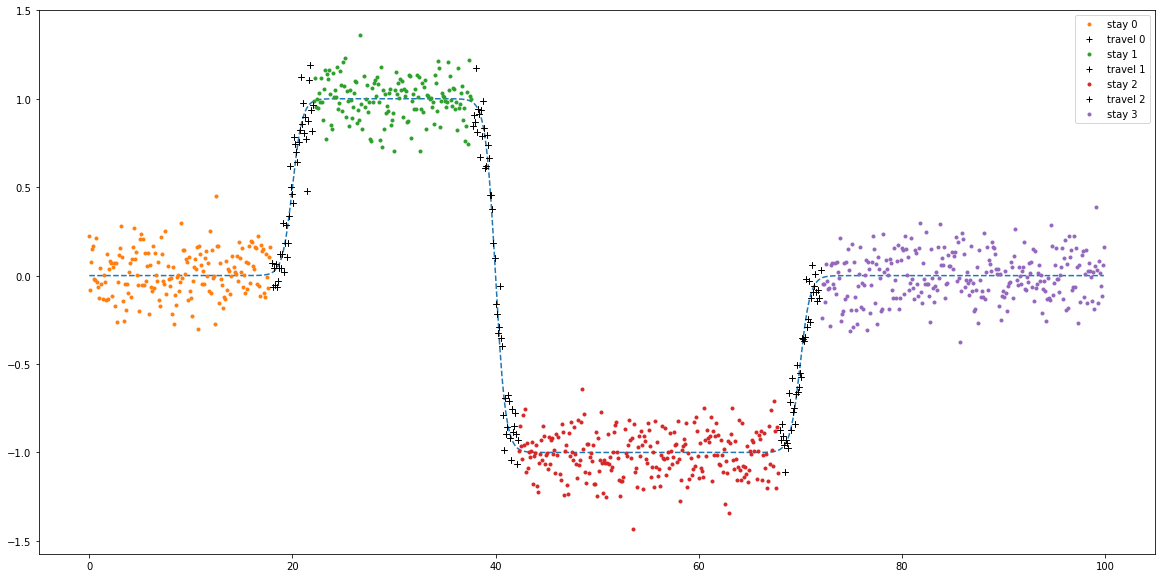

In [277]:
plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')

# Get the starts and stops of the stays
stay_starts = [0]
for n,m in list(zip(stay_mask[:-1].tolist(),stay_mask[1:].tolist())):
    #print(n+1, n,n+1 - n)
    #print(m,n)
    if m - n != 1:
        stay_starts += [n,m]
        
ind,sind,tind=0,0,0
mm = 0
for m,n in list(zip(stay_starts[:-1],stay_starts[1:])):
    #print(ind,m,n)
    st_mask = np.array(range(m,n))
    
    if ind%2==0:
        plt.plot(xxx[st_mask], yyyn[st_mask], '.', label=f'stay {tind}')
        sind+=1
    else:
        plt.plot(xxx[trav_mask], yyyn[trav_mask], 'k+', label=f'travel {tind}')
        tind+=1
    
    ind += 1
    mm = n

plt.plot(xxx[mm:], yyyn[mm:], '.', label=f'stay {sind}')
    
#plt.plot(xxx[trav_mask], yyyn[trav_mask], 'kx', label='travels')
plt.legend();

## With `pandas`

In [188]:
import pandas as pd

In [232]:
pdf = pd.DataFrame({'x':xxx, 'y':yyyn, 'stay':list(classification_map.values())})

In [233]:
pdf.head()

,x,y,stay
0,0.0,0.221375,1
1,0.1,-0.082725,1
2,0.2,0.077445,1
3,0.3,0.148748,1
4,0.4,0.166209,1


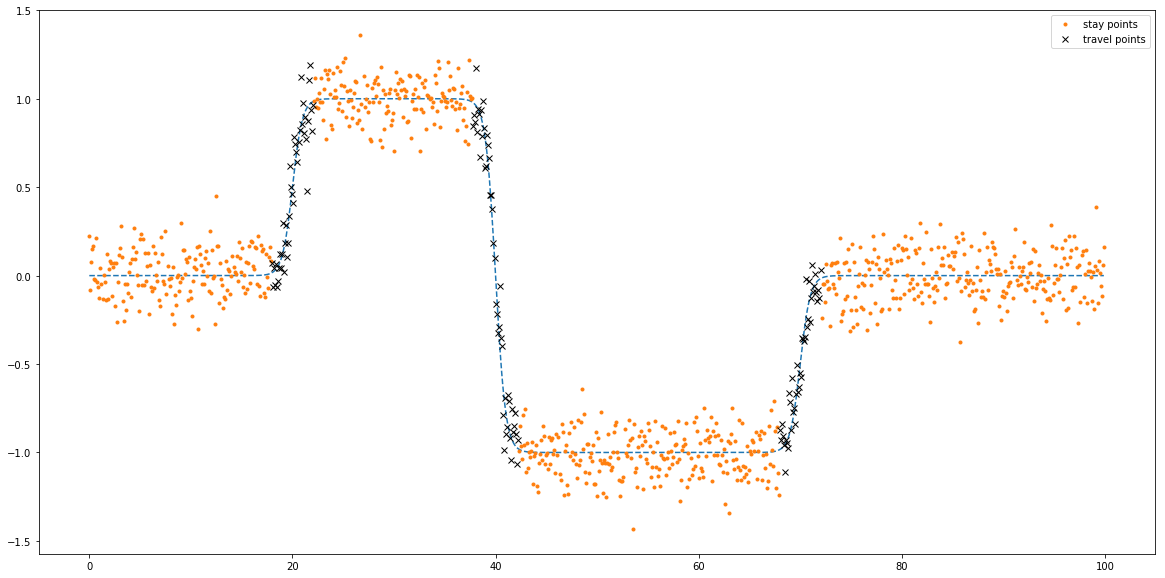

In [234]:
plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')
plt.plot(pdf[pdf['stay'].astype(bool)].x, 
         pdf[pdf['stay'].astype(bool)].y, 'C1.',label='stay points')
plt.plot(pdf[pdf['stay'].astype(bool)==False].x, 
         pdf[pdf['stay'].astype(bool)==False].y, 'kx',label='travel points')
plt.legend();

In [235]:
# Create an ID for each segment 
pdf['segment_id'] = 0
ind,sind,tind=0,0,0
nn=0
for m,n in list(zip(stay_starts[:-1],stay_starts[1:])):
    #print(ind,m,n)
    st_mask = np.array(range(m,n))
    
    pdf.loc[m:n,'segment_id'] = ind
    
    ind += 1
    nn = n
pdf.loc[nn:,'segment_id'] = ind    

In [236]:
pdf[pdf['segment_id']==3].head()

,x,y,stay,segment_id
377,37.7,1.005369,1,3
378,37.8,0.843406,0,3
379,37.9,0.906016,0,3
380,38.0,0.867079,0,3
381,38.1,1.175984,0,3


In [237]:
pdf.tail()

,x,y,stay,segment_id
995,99.5,0.013895,1,6
996,99.6,-0.057337,1,6
997,99.7,-0.116553,1,6
998,99.8,0.058170,1,6
999,99.9,0.160952,1,6


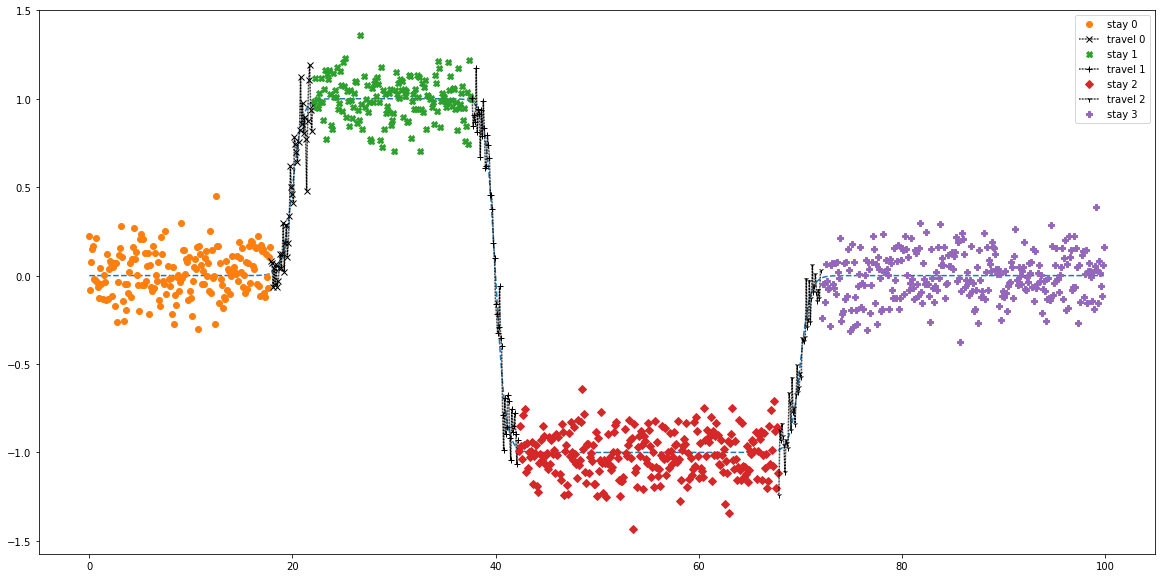

In [239]:
plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')

stay_marks = ['o','X', 'D','P', 's','*','^']
trav_marks = ['x','+','1','2','3','4']

tind,sind = 0,0
for m in pdf.segment_id.unique().tolist():
    
    #print(ind,m,n)
    st_mask = np.array(range(m,n))
    
    pdf_sub = pdf[pdf['segment_id']==m]
    xs = pdf_sub.x.values
    ys = pdf_sub.y.values
    
    if m%2==0:
        plt.plot(xs, ys, marker=stay_marks[sind%7], linestyle='',label=f'stay {sind}')
        sind+=1
    else:
        plt.plot(xs, ys, color='k', marker=trav_marks[tind%6], linestyle='',dashes=[0.5,0.5],label=f'travel {tind}')
        tind+=1

plt.legend();

#### Now, sparsify the original data with a mask

In [240]:
new_mask = get_mask(xxx.size, 0.25)

In [243]:
pdf['mask'] = new_mask

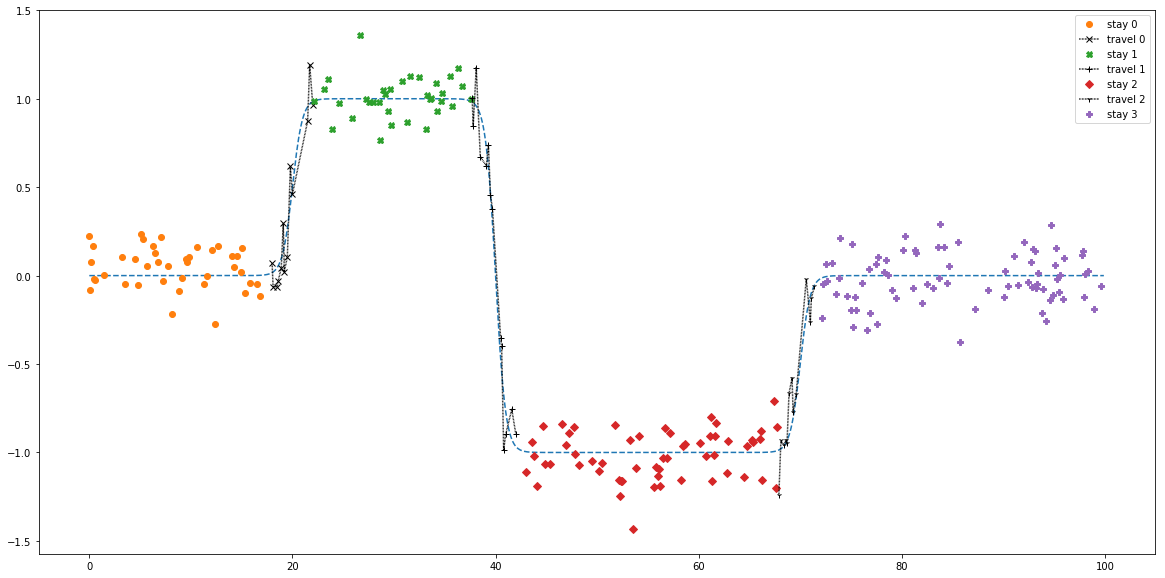

In [245]:
plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')

stay_marks = ['o','X', 'D','P', 's','*','^']
trav_marks = ['x','+','1','2','3','4']

tind,sind = 0,0
for m in pdf.segment_id.unique().tolist():
    
    #print(ind,m,n)
    st_mask = np.array(range(m,n))
    
    pdf_sub = pdf[(pdf['mask'])&(pdf['segment_id']==m)]
    xs = pdf_sub.x.values
    ys = pdf_sub.y.values
    
    if m%2==0:
        plt.plot(xs, ys, marker=stay_marks[sind%7], linestyle='',label=f'stay {sind}')
        sind+=1
    else:
        plt.plot(xs, ys, color='k', marker=trav_marks[tind%6], linestyle='',dashes=[0.5,0.5],label=f'travel {tind}')
        tind+=1

plt.legend();